In [1]:
import sys

import networkx as nx
import gzip
#import pyfrost
import numpy
from collections import defaultdict
import matplotlib.pyplot as plot
#import CCGG_extension as CCGG
import json
import AGG
import pandas as pd
#import py4cytoscape as p4c

In [2]:
#! pip3 install py4cytoscape

In [95]:
filename = './hprc_anchor_graphical_genome_k31.gfa'
graph = AGG.GraphicalGenome(filename)


In [96]:
# hot fix for strain attributes
edgelist = graph.edges.keys()
for edge in edgelist:
    strainlist = graph.edges[edge]['strain']
    S = set()
    for strain in strainlist:
        s = strain.split('ccs')[-1]
        if s.startswith("_"):
            s = s[1:]
        S.add(s)
    graph.edges[edge]['strain'] = sorted(S)


In [97]:
# validate edge supports
edgelist = graph.edges.keys()
for edge in edgelist:
    readlist = graph.edges[edge]['reads']
    if len(readlist) < 4:
        print(edge, graph.edges[edge],graph.incoming[edge])

E11922.0000 {'reads': ['NC_012920'], 'strain': ['NC_012920'], 'seq': 'GATCA'} ['SOURCE']
E11922.0001 {'reads': ['NC_012920'], 'strain': ['NC_012920'], 'seq': 'CAATTGAATGTCTGCACAGCCACTTTCCAC'} ['A000007']
E11922.0002 {'reads': ['NC_012920'], 'strain': ['NC_012920'], 'seq': 'TCACCCTCTAAATCACCACGATCAAAAGGAACAAGCATCAAGCAC'} ['A000023']
E11922.0003 {'reads': ['NC_012920'], 'strain': ['NC_012920'], 'seq': 'CCAGGTCGGTTTCTATCTACNTTCAAATTCC'} ['A000099']
E11922.0004 {'reads': ['NC_012920'], 'strain': ['NC_012920'], 'seq': 'TAATAGCTATAGCAATAAAACTAGGAATAGCCCC'} ['A000153']
E11922.0005 {'reads': ['NC_012920'], 'strain': ['NC_012920'], 'seq': 'TGAGCGGGCA'} ['A000285']
E11922.0006 {'reads': ['NC_012920'], 'strain': ['NC_012920'], 'seq': 'TATTGCAGCCCTAGCAACACTCCACCT'} ['A000493']
E11922.0007 {'reads': ['NC_012920'], 'strain': ['NC_012920'], 'seq': 'GCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCACGATG'} ['A000533']


In [98]:
def find_all_reads(graph):
    read_sets = set()
    edgelist = graph.edges.keys()
    for item in edgelist:
        readlist = graph.edges[item]['reads']
        for read in readlist:
            read_sets.add(read)
    return read_sets

read_sets = find_all_reads(graph)
len(read_sets)

11920

In [99]:
# find deletions:
edgelist = graph.edges.keys()
Info = []
for edge in edgelist:
    src = graph.incoming[edge][0]
    dst = graph.outgoing[edge][0]
    # find reference path
    if src == "SOURCE" or dst == "SINK":
        continue
    paths = Find_all_Path_between_anchors(graph, src, dst, {"NC_012920"})
    if len(paths.subpath)<1:
        continue
    #assert len(paths.subpath) == 1, print(len(paths.subpath),src,dst)
    ref_seq = reconstruct_path_seq(graph, paths.subpath[0][0][1:-1])
    
    edge_seq = graph.edges[edge]['seq']
    
    diff = len(edge_seq) - len(ref_seq)
    if numpy.absolute(diff) > 5:
        print(src, graph.anchor[src]['pos'], dst, graph.anchor[dst]['pos'], diff, len(graph.edges[edge]['reads']), graph.edges[edge]['strain'])
        Info.append((src, graph.anchor[src]['pos'], dst, graph.anchor[dst]['pos'], diff, len(set(graph.edges[edge]['reads'])), len(set(graph.edges[edge]['strain']))))


A000009 272 A000011 317 6 7 ['HG00438', 'HG01358', 'HG01361', 'HG02723']
A000266 8228 A000268 8306 -9 670 ['HG01258', 'HG01361', 'HG01928']
A000266 8228 A000268 8306 -10 4 ['HG01258', 'HG01361']
A000265 8189 A000268 8306 -8 4 ['HG01258', 'HG01361']
A000265 8189 A000268 8306 -10 4 ['HG01258', 'HG01361']
A000266 8228 A000268 8306 -8 27 ['HG01258', 'HG01361', 'HG01928']
A000266 8228 A000270 8343 -10 5 ['HG01258', 'HG01361']
A000265 8189 A000268 8306 -8 7 ['HG01258', 'HG01361']
A000265 8189 A000268 8306 -8 17 ['HG01258', 'HG01361']
A000266 8228 A000268 8306 -8 4 ['HG01258']
A000266 8228 A000270 8343 -10 4 ['HG01258', 'HG01361']
A000265 8189 A000268 8306 -10 6 ['HG01258', 'HG01361']
A000266 8228 A000268 8306 -8 5 ['HG01258', 'HG01361']
A000015 462 A000017 526 6 12 ['HG03579']


In [100]:
df = pd.DataFrame(Info, columns = ["src","src_coord", "dst", "dst_coord", "length_diff_from_refseq", "reads_support", "num_of_sample"])
df = df.sort_values(by = ['src_coord'])
df

,src,src_coord,dst,dst_coord,length_diff_from_refseq,reads_support,num_of_sample
0,A000009,272,A000011,317,6,7,4
13,A000015,462,A000017,526,6,12,1
3,A000265,8189,A000268,8306,-8,4,2
4,A000265,8189,A000268,8306,-10,4,2
7,A000265,8189,A000268,8306,-8,7,2
8,A000265,8189,A000268,8306,-8,17,2
11,A000265,8189,A000268,8306,-10,6,2
1,A000266,8228,A000268,8306,-9,670,3
2,A000266,8228,A000268,8306,-10,4,2
5,A000266,8228,A000268,8306,-8,27,3


# 8239-8306:
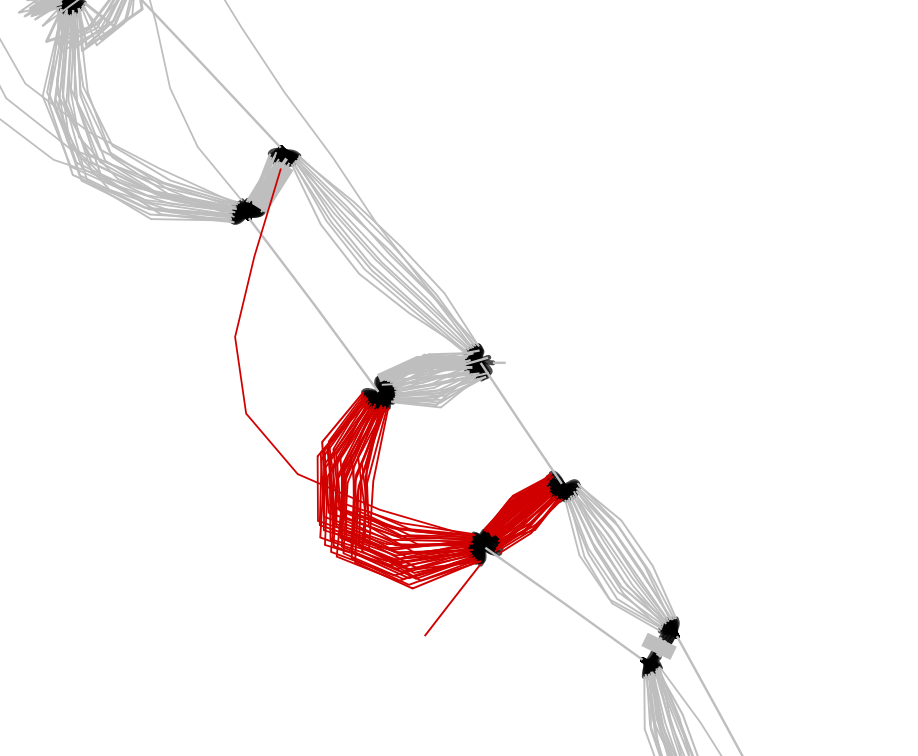

In [101]:
for edge in graph.incoming["A000268"]:
    if len(graph.edges[edge]['reads'])==703:
        print(edge)
    #print(edge+',')

In [102]:
# for read in graph.edges[edge]['reads']:
#     if '012920' in read:
#         print(read)

In [103]:
paths.subpath[0][0]

['A000493', 'E11922.0006', 'A000495']

In [104]:

class SubGraph:
    def __init__(self, graph, samplelist):
        self.anchor, self.edges, self.outgoing, self.incoming = self.reconstruct_sample_subgraph(graph, samplelist)

    def reconstruct_sample_subgraph(self, graph, samplelist):
        Anchor_dict = {}
        Edge_dict = {}
        Outgoing = {}
        Incoming = {}

        edgelist = list(graph.edges.keys())
        nodelist = []
        
        for edge in edgelist:
            if len(set(samplelist) & set(graph.edges[edge]['strain'])) > 0:
                Edge_dict[edge] = graph.edges[edge]
                src = graph.incoming[edge][0]
                dst = graph.outgoing[edge][0]
                
                Edge_dict[edge]['src'] = src
                Edge_dict[edge]['dst'] = dst
                
                Incoming[edge] = graph.incoming[edge]
                Incoming[dst] = Incoming.get(dst, []) + [edge]
                
                Outgoing[edge] = graph.outgoing[edge]
                Outgoing[src] = Outgoing.get(src, []) + [edge]
                
                nodelist += graph.incoming[edge]
                nodelist += graph.outgoing[edge]

        nodelist = list(set(nodelist))
        for node in nodelist:
            if node.startswith("A"):
                Anchor_dict[node] = graph.anchor[node]      
        return Anchor_dict, Edge_dict, Outgoing, Incoming

In [105]:
sample = "HG002"
subgraph = SubGraph(graph, [sample])

In [106]:

def read_sets_supporting_path(graph, samplelist, subgraph):
    read_sets = set()
    edgelist = subgraph.edges.keys()
    for item in edgelist:
        readlist = graph.edges[item]['reads']
        for sample in samplelist:
            for read in readlist:
                if read.endswith(sample):
                    read_sets.add(read)
    return read_sets

#read_sets = read_sets_supporting_path(graph, sample, subgraph)

In [107]:
# series-parallel the graph


In [108]:
# edgelist = subgraph.edges.keys()

# for edge in edgelist:
#     assert sample in subgraph.edges[edge]['strain']

In [109]:
nodelist = sorted(graph.anchor.keys())
start_node = nodelist[0]
end_node = nodelist[-1]
start_node, end_node, len(read_sets)

('A000001', 'A000533', 11920)

In [110]:
# for edge in subgraph.incoming['SINK']:
#     del subgraph.edges[edge]
#read_sets

# delete all the source and Sink edges

In [111]:
edgelist = graph.outgoing['SOURCE'] + graph.incoming['SINK']
#len(edgelist), len("".join([graph.edges[edge]['seq'] for edge in edgelist]))
for edge in edgelist:
    del graph.edges[edge]
    srclist = graph.incoming[edge]
    dstlist = graph.outgoing[edge]
    del graph.incoming[edge]
    del graph.outgoing[edge]
    
    for node in srclist:
        graph.outgoing[node].remove(edge)
    for node in dstlist:
        graph.incoming[node].remove(edge)

In [112]:
class Find_all_Path_between_anchors:
    def __init__(self, graph, start, end, read_sets):
        self.subpath = []
        self.initial_set = read_sets
        self.find_path(graph, start, end, [], 0, self.initial_set)
        
    def find_path(self, g, start, end, sofar, depth, readset):
        
        if start == end:
            sofar1 = sofar + [end]
            if len(readset)>0:
                self.subpath.append((sofar1, readset))
            return
        
        # path not supported
        if len(readset) <1:
            return  
        
        # path not circular
        if start == "SINK":
            return
        
        depth1 = depth+ 1
        
        
        for dst in g.outgoing[start]:   
            # consider the read set in the latest 10 intervals
            if dst.startswith("E"):
                readset1 = readset & set(g.edges[dst]['reads'])
            else:
                readset1 = readset
             
            self.find_path(g, dst, end, sofar = sofar + [start], depth = depth1, readset = readset1)
            


In [113]:
def reconstruct_path_seq(graph, path):
    seq = ""
    for item in path:
        if item.startswith('A'):
            seq += graph.anchor[item]['seq']
        elif item.startswith("E"):
            seq += graph.edges[item]['seq']
        else:
            item += ""
    return seq

In [114]:
class Get_Series_Parallel_Graph:
    
    def __init__(self, graph, read_set):
        self.initial_set = read_set | {'NC_012920', '_012920'} # always keep the reference pat
        self.nodelist = self.series_parallel_graph_nodelist(graph)
        self.anchor, self.edges, self.outgoing, self.incoming = self.series_parallel_graph(self.nodelist, graph)
    
    def series_parallel_graph_nodelist(self, subgraph):
        start_node = sorted(subgraph.anchor.keys())[0]
        Nodelist = [start_node]

        edgelist = subgraph.outgoing[start_node]
        node_candidate = []
        for edge in edgelist:
            nodelist = subgraph.outgoing[edge]
            node_candidate += nodelist
            if nodelist[0] not in subgraph.anchor:
                    continue
        if len(node_candidate) <1:
            return
        
        node_candidate = sorted(node_candidate)
        node = node_candidate[-1]
        Nodelist.append(node) # append the furthest node
        
        node_avoid_set = set()

        while node != start_node:
            edgelist = subgraph.outgoing[node]
            node_candidate = []
            for edge in edgelist:
                nodelist = subgraph.outgoing[edge]
                # exclude deadend
                if "SINK" in nodelist:
                    continue
                if nodelist[0] not in subgraph.anchor:
                    continue
                if nodelist[0] not in subgraph.outgoing:
                    continue
                node_candidate += nodelist
            if len(node_candidate) <1:
                return

            node_candidate = sorted(node_candidate)
            node = node_candidate[-1]
            Nodelist.append(node) # append the furthest node  
                
        return Nodelist
    
    def series_parallel_graph(self, Nodelist, subgraph):
        Node_dict = {}
        Edge_dict = {}
        Outgoing_dict = {}
        Incoming_dict = {}
        for i, node in enumerate(Nodelist[:-1]):
            start_node = node
            end_node = Nodelist[i+1]
            Node_dict[start_node] = subgraph.anchor[start_node]

            path = Find_all_Path_between_anchors(subgraph, start_node, end_node, read_sets)
            #print(start_node,end_node, len(path.subpath))
            index = 0
            for p, rs in path.subpath:
                edgename = 'E%05d.%04d' % (int(start_node[1:]), index)
                seq = reconstruct_path_seq(subgraph, p[1:-1])
                Edge_dict[edgename] = {}
                Edge_dict[edgename]['seq'] = seq
                Edge_dict[edgename]['src'] = start_node
                Edge_dict[edgename]['dst'] = end_node

                Outgoing_dict[start_node] = Outgoing_dict.get(start_node, []) + [edgename]
                Outgoing_dict[edgename] = [end_node]

                Incoming_dict[end_node] = Incoming_dict.get(end_node, []) + [edgename]
                Incoming_dict[edgename] = [start_node]
        return Node_dict, Edge_dict, Outgoing_dict, Incoming_dict

In [115]:
len(read_sets)

11920

In [116]:
%time series_parallelgraph = Get_Series_Parallel_Graph(graph, read_sets)

KeyboardInterrupt: 

In [84]:
#len(series_parallelgraph.anchor), len(graph.anchor)
for edge in edgelist:
    if "NC_012920" in graph.edges[edge]['strain']:
        print(graph.edges[edge]['reads'])
        break

['m54329U_201103_231616/6359354/ccs_HG002', 'm54329U_201103_231616/6685555/ccs_HG002', 'm54329U_201103_231616/37684585/ccs_HG002', 'm54329U_201103_231616/39455569/ccs_HG002', 'm54329U_201103_231616/51970410/ccs_HG002', 'm54329U_201103_231616/71960591/ccs_HG002', 'm54329U_201103_231616/135660096/ccs_HG002', 'm54329U_201103_231616/143852432/ccs_HG002', 'm54329U_201103_231616/68356318/ccs_HG002', 'm54329U_201103_231616/166397033/ccs_HG002', 'm54329U_201103_231616/109970129/ccs_HG002', 'm54329U_201103_231616/46597678/ccs_HG002', 'm54329U_201103_231616/6883234/ccs_HG002', 'm54329U_201103_231616/116393834/ccs_HG002', 'm64043_200710_174426/11666850/ccs_HG00438', 'm64043_200710_174426/13960288/ccs_HG00438', 'm64043_200710_174426/33688151/ccs_HG00438', 'm64043_200710_174426/34406403/ccs_HG00438', 'm64043_200710_174426/36045408/ccs_HG00438', 'm64043_200710_174426/46071965/ccs_HG00438', 'm64043_200710_174426/66193472/ccs_HG00438', 'm64043_200710_174426/80019972/ccs_HG00438', 'm64043_200710_174426

In [43]:
%time series_parallelgraph = Get_Series_Parallel_Graph(subgraph, read_sets)

['A000001', 'A000003', 'A000005', 'A000007', 'A000009', 'A000011', 'A000013', 'A000015', 'A000017', 'A000019', 'A000021', 'A000025', 'A000027', 'A000031', 'A000033', 'A000035', 'A000038', 'A000040', 'A000042', 'A000043', 'A000045', 'A000047', 'A000048', 'A000052', 'A000054', 'A000057', 'A000059', 'A000062', 'A000064', 'A000065', 'A000068', 'A000070', 'A000073', 'A000076', 'A000079', 'A000082', 'A000084', 'A000086', 'A000087', 'A000088', 'A000092', 'A000093', 'A000096', 'A000097', 'A000101', 'A000102', 'A000104', 'A000107', 'A000108', 'A000110', 'A000112', 'A000114', 'A000116', 'A000119', 'A000122', 'A000125', 'A000126', 'A000128', 'A000131', 'A000133', 'A000135', 'A000136', 'A000138', 'A000141', 'A000142', 'A000146', 'A000147', 'A000149', 'A000150', 'A000153', 'A000155', 'A000157', 'A000158', 'A000160', 'A000163', 'A000165', 'A000168', 'A000170', 'A000172', 'A000173', 'A000176', 'A000178', 'A000181', 'A000185', 'A000186', 'A000187', 'A000189', 'A000193', 'A000194', 'A000197', 'A000198'

In [117]:
# validation
def validate_sp_graph(series_parallelgraph):
    nodelist = series_parallelgraph.anchor.keys()
    for node in nodelist:
        edgelist = series_parallelgraph.outgoing[node]
        outgoing_nodelist = []
        for edge in edgelist:
            outgoing_nodelist.append(series_parallelgraph.edges[edge]['dst'])
            outgoing_nodelist.append(series_parallelgraph.outgoing[edge][0])
        outgoing_nodelist = set(outgoing_nodelist)
        assert len(outgoing_nodelist) == 1

In [45]:
validate_sp_graph(series_parallelgraph)
graph.edges['E00000.0001'].keys()

dict_keys(['reads', 'strain', 'seq', 'src', 'dst'])

# how many distinct haplotypes existing in the 46 samples?

In [118]:
itemlist = series_parallelgraph.outgoing.keys()
haplotype_num = []
for item in itemlist:
    if item.startswith("A"):
        haplotype_num.append(len(series_parallelgraph.outgoing[item]))
max(haplotype_num)

7

# find lower bound

In [75]:
graph.edges['E00000.0065']['dst'], graph.outgoing['E00000.0065'], subgraph.outgoing['E00000.0065'],

('A000029', ['A000029'], ['A000029'])

In [122]:
edgelist = graph.outgoing['A000533']
samplelist = []
for edge in edgelist:
    samplelist += graph.edges[edge]['strain']
    if "NC_012920" in graph.edges[edge]['strain']:
        print(edge, graph.incoming[edge], graph.outgoing[edge])
    try:
        if sample in graph.edges[edge]['strain']:
            print(edge, graph.incoming[edge], graph.outgoing[edge])
    except:
        print(edge, graph.incoming[edge], graph.outgoing[edge])
print(samplelist)

['HG002', 'HG00621', 'HG00733', 'HG01071', 'HG01109', 'HG01123', 'HG01175', 'HG01358', 'HG01928', 'HG01952', 'HG01978', 'HG02080', 'HG02109', 'HG02148', 'HG02257', 'HG02622', 'HG02818', 'HG03453', 'NA18906', 'NA21309', 'HG00621', 'HG00733', 'HG01123', 'HG01358', 'HG01952', 'HG02148', 'HG03453', 'NA21309', 'HG00621', 'HG00733', 'HG01071', 'HG01123', 'HG01358', 'HG01952', 'HG02080', 'HG02148', 'HG02257', 'HG02622', 'HG02818', 'NA18906', 'NA21309', 'HG00621', 'HG01109', 'HG01123', 'HG01358', 'HG01952', 'HG02148', 'HG00621', 'HG02148', 'HG02818', 'NA21309', 'HG00621', 'HG00733', 'HG01952', 'HG02080', 'HG02148', 'HG02257', 'HG02818', 'HG03453', 'NA21309', 'HG00733', 'HG01123', 'HG02080', 'HG02818', 'HG03453', 'NA21309', 'HG00733', 'HG01123', 'HG01358', 'HG02818', 'HG03453', 'NA18906', 'NA21309', 'HG00733', 'HG01123', 'HG01358', 'HG02818', 'HG03453', 'NA21309', 'HG01123', 'HG01358', 'HG01952', 'HG02080', 'HG02148', 'HG02257', 'HG03453', 'NA21309', 'HG01952', 'HG02818', 'NA21309', 'HG02145', 

In [119]:
sample = 'HG02559'
subgraph = SubGraph(graph, ['HG02559', "NC_012920"]) # always have reference path in the subgraph
edgelist = subgraph.edges.keys()
for edge in edgelist:
    if 'HG02559' in subgraph.edges[edge]['strain']:
        continue
    
read_sets = read_sets_supporting_path(graph, sample, subgraph)
print('A000029' in subgraph.incoming)
spgraph = Get_Series_Parallel_Graph(subgraph, read_sets)
maximal_parallel_path = []
nodelist = spgraph.anchor.keys()
print(nodelist)
for node in nodelist:
    maximal_parallel_path.append(len(spgraph.outgoing[node]))
print(sample, len(read_sets), max(maximal_parallel_path))

# #validate_sp_graph(spgraph)
# maximal_parallel_path = []
# nodelist = spgraph.anchor.keys()
# for node in nodelist:
#     maximal_parallel_path.append(len(spgraph.outgoing[node]))
# print(sample, len(read_sets), max(maximal_parallel_path))
# Info.append((sample, len(read_sets),max(maximal_parallel_path) ))

True


KeyError: 'A000533'

In [ ]:
subgraph.incoming["A000029"], 
edgelist = graph.outgoing['A000029']


In [128]:
from itertools import combinations
from random import sample


def find_sample_list(graph):
    samplelist = set()
    edgelist = graph.edges.keys()
    for item in edgelist:
        samples = graph.edges[item]['strain']
        samplelist = samplelist | set(samples)
    return list(samplelist)

samplelist = find_sample_list(graph)
Info = []

# combination of 2
experimentlist = sample(list(combinations(samplelist, 2)),3) + sample(list(combinations(samplelist, 3)),3) + sample(list(combinations(samplelist, 5)),1)

for sample in experimentlist:
    print(list(sample))
    

['HG03540', 'HG03516']
['HG00733', 'HG00438']
['HG03453', 'HG01928']
['HG01978', 'NA18906', 'HG01175']
['HG002', 'HG00735', 'HG02572']
['HG00673', 'HG01358', 'HG02622']
['HG03540', 'HG00733', 'HG01109', 'HG02818', 'HG01071']


In [ ]:
for sample in experimentlist:
    sample = list(sample) + ['NC_012920']
    #print(sample)
    try:
        subgraph = SubGraph(graph, sample)
        read_sets = read_sets_supporting_path(graph, sample, subgraph)
        spgraph = Get_Series_Parallel_Graph(subgraph, read_sets)
        #validate_sp_graph(spgraph)
        maximal_parallel_path = []
        nodelist = spgraph.anchor.keys()

        for node in nodelist:
            maximal_parallel_path.append(len(spgraph.outgoing[node]))
        print(sample, len(read_sets), max(maximal_parallel_path))
        Info.append((sample, len(read_sets),max(maximal_parallel_path) ))
        
    except:
        print(sample, "Not successful")


['HG03540', 'HG03516', 'NC_012920'] Not successful
['HG00733', 'HG00438', 'NC_012920'] Not successful


Text(0, 0.5, 'haplotype number')

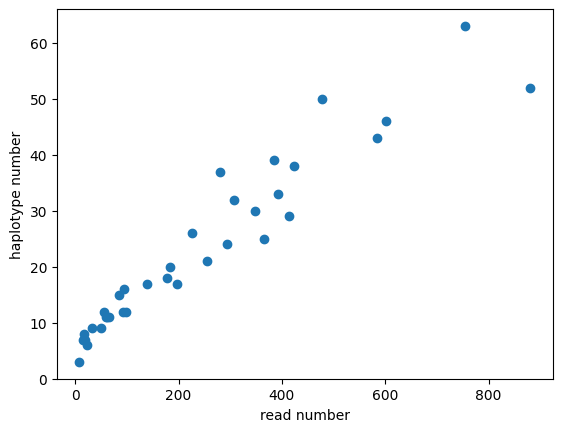

In [4]:
df = pd.read_csv("./Haplotype_number.csv", index_col=0)
df = df.sort_values(by = 'Read_num')
plot.scatter(df['Read_num'].values, df['Hap_num'].values)
plot.xlabel("read number")
plot.ylabel("haplotype number")

In [17]:
df

,Sample,Read_num,Hap_num
16,HG00741,8,3
29,HG002,15,7
30,HG01106,17,8
25,HG01928,18,7
22,HG02622,22,6
32,HG03098,32,9
5,HG02486,50,9
14,HG01175,56,12
8,HG01109,60,11
17,HG00438,61,11


In [16]:
min(df['Hap_num'].values), sum(df['Hap_num']>10)/len(df)

(3, 0.8)

Text(0, 0.5, 'Number of Samples')

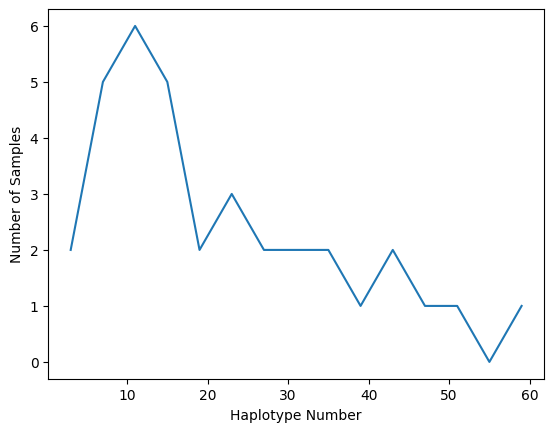

In [14]:
y,x = numpy.histogram(df['Hap_num'].values, bins = 15)
plot.plot(x[:-1], y)
plot.xlabel("Haplotype Number")
plot.ylabel("Number of Samples")

In [ ]:
#subgraph.anchor.keys()

# find upper bound

In [40]:
class Find_all_circular_Path:
    def __init__(self, graph, start, end, read_sets, interval_length):
        self.subpath = []
        self.partial = []
        self.initial_set = read_sets
        self.find_circle(graph, start, interval_length , [], 0, read_sets)
        
        
        
    def find_circle(self, g, start, interval_length, sofar, depth, readset):
        
        # visited (circular)
        if start in set(sofar):
            print(len(readset))
            sofar1 = sofar
            if len(readset)>0:
                self.subpath.append((sofar1, readset))
            return
        
        # path not supported
        if len(readset) <1:
            sofar1 = sofar
            if len(sofar1) > len(graph.anchor.keys())*1.5:
                self.partial.append((sofar1, readset))
            return  
        
        # path not circular
        if start == "SINK":
            return
        
        depth1 = depth+ 1
        
        
        for dst in g.outgoing[start]:   
            # consider the read set in the latest 10 intervals
            if len(sofar)<interval_length:
                itemlist = sofar
            else:
                itemlist = sofar[-interval_length:]
            readset1 = self.initial_set
            
            for item in itemlist:
                if item.startswith("E"):
                    readset1 = readset1 & set(g.edges[item]['reads'])
                else:
                    readset1 = readset1
                    
            if dst.startswith("E"):
                readset1 = readset1 & set(g.edges[dst]['reads'])

                
            self.find_circle(g, dst, interval_length, sofar = sofar + [start], depth = depth1, readset = readset1)

In [41]:
distance  = [ 100, 150, 200]
hap = []
for d in distance:
    path.subpath = []
    path.partial = []
    path = Find_all_circular_Path(subgraph, start_node, end_node, read_sets, d)
    hap.append(len(path.subpath))
    print(d, len(path.subpath))

4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
4
1
1
100 96
2
1
2
1
2
1
2
1
2
1
2
1
150 12
200 0


In [34]:
hap

[]

In [39]:
len(path.subpath), len(path.partial)

(0, 0)

In [7]:
# Paths = []
# maximal = 15
# source = nodelist[0]
# target = nodelist[-1]
# visited = set()
# sampleid = "HG002"

# def find_paths(g, start, end, sofar = [], depth = 0):
#     global Paths, maximal, visited, sampleid
#     # termination by node
#     #print(start, end)
    
#     if str(start) == str(end):   
#         sofar1 = sofar
#         Paths.append((sofar1))
#         return 
    

            
#     # check reads
#     if len(sofar)>2:
#         for item in sofar:
#             if item.startswith("E"):
#                 readlist = [r for r in g.edges[item]['reads'] if r.endswith(sampleid)]
#                 readsets_up = set(readlist)
#                 break
#         for item in sofar:
#             if item.startswith("E"):
#                 readlist = [r for r in g.edges[item]['reads'] if r.endswith(sampleid)]
#                 readsets_up = readsets_up.intersection(set(readlist))    

#         if len(readsets_up)<1:
#             return
    
#     depth1 = depth + 1
    
#     if start in visited:
#         print(sofar)
#         return
    
#     if start == "SINK":
#         print(start, sofar)
#         return

#     for dst in g.outgoing[start]:   
#         find_paths(g, dst, end, sofar = sofar + [start], depth = depth1)



In [66]:
find_paths(subgraph, source, target)

In [53]:
'E00016.0010' in subgraph.edges, set(graph.edges['E00001.0079']['reads'])

(False,
 {'m64076_200201_051547/96799548/ccs_HG01358',
  'm64043_200206_173947/110103375/ccs_HG02818',
  'm64043_200827_191459/49351479/ccs_HG01109',
  'm64076_200125_231256/178587750/ccs_HG02257',
  'm64043_200206_173947/45746608/ccs_HG02818',
  'm64043_191221_024136/47907957/ccs_HG02723',
  'm54329U_200201_051510/106564336/ccs_HG01123',
  'm64076_200201_051547/59180860/ccs_HG01358',
  'm54329U_200215_021808/168821587/ccs_HG02486',
  'm64043_191227_185626/148048012/ccs_NA20129',
  'm64136_200827_191603/107806903/ccs_HG01243',
  'm54329U_200215_021808/163840339/ccs_HG02486',
  'm64043_200618_201934/66913386/ccs_HG01175',
  'm64043_200206_173947/114820047/ccs_HG02818',
  'm64136_200827_191603/72287956/ccs_HG01243',
  'm64136_200827_191603/123275268/ccs_HG01243',
  'm64043_200206_173947/139199863/ccs_HG02818',
  'm64043_200716_182902/135987304/ccs_HG00673',
  'm64136_201014_213617/18743366/ccs_HG02055',
  'm64136_201014_213617/149685742/ccs_HG02055',
  'm64136_200710_174522/40633452/ccs_

In [40]:
graph.outgoing['E00016.0010']

['A000533']

In [50]:
len(Paths)

29081316